In [52]:
%%time
import ijson
import pandas as pd
from pathlib import Path

#file year 
year = 2025
file_path = f"new_amplitude_export_{year}.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]
path = Path(f"{year}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)
#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        df = df[columns_keep]
        df.to_csv(output_csv, index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'new_amplitude_export_2025.json'

In [3]:
%%time
import ijson
import pandas as pd
from pathlib import Path

#file chunk 
part = 1
file_path = f"new_export/amplitude_export_chunk_{part}_anonymized.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]

path = Path(f"{part}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        print(df.shape)
        df = df[columns_keep]
        print(df.shape)
        df.to_csv(output_csv, index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'new_export/amplitude_export_chunk_1_anonymized.json'

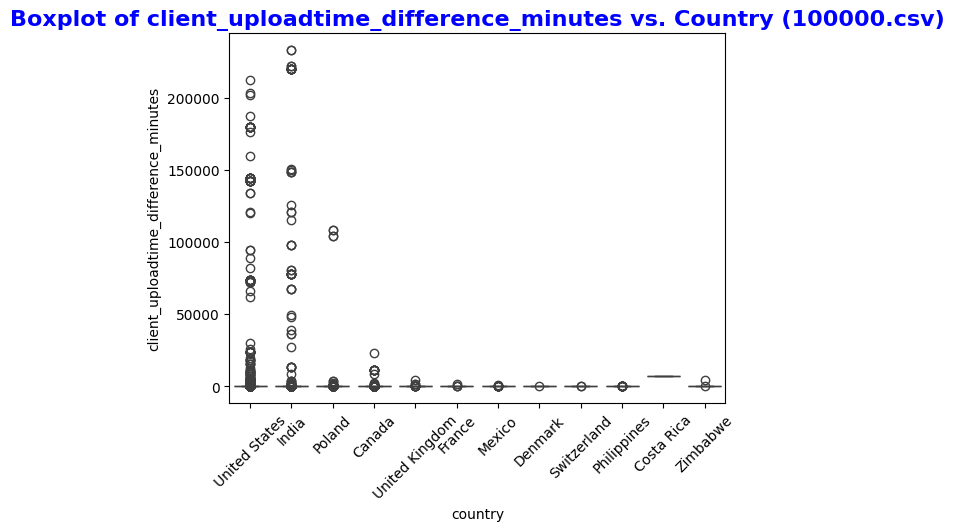

In [4]:
import pandas as pd
import numpy as new_export
import matplotlib.pyplot as plt
import seaborn as sns
# if getting error message, make sure to install matplotlib using pip install

## here is the specified file the code will examine
PATH = '1_csv/amplitude_export_chunk_1_anonymized_subchunk_0_100000.csv'
df = pd.read_csv(PATH)
# See the first couple rows of dataset
df.head()

# Generates a summary of statistics for the columns in the dataste
df.describe(include='all')

df['client_event_time'] = pd.to_datetime(df['client_event_time'])
df['client_upload_time'] = pd.to_datetime(df['client_upload_time'])


# Add new columns for 'event_date' and 'event_time'
#df['client_event_timestamp'] = df['client_event_time'].dt.time   # Extracts the time part
#df['client_upload_timestamp'] = df['client_upload_time'].dt.time   # Extracts the time part

df['time_difference'] = df['client_upload_time'] - df['client_event_time']
df['time_difference_minutes'] = df['time_difference'].dt.total_seconds() / 60


# Created a new column titled client_uploadtime_difference_minutes which combined client_event_time and client_upload_tine

df['client_uploadtime_difference_minutes'] = df['time_difference'].dt.total_seconds() / 60

# Summary of statistics on the upload time from client
df['time_difference'].describe()

df.loc[df['time_difference'].idxmax()]

#pd.crosstab(df['country'], df['device_type'])
df.groupby('device_type')['client_uploadtime_difference_minutes'].mean()

sns.boxplot(x='country', y='client_uploadtime_difference_minutes', data=df)
plt.title('Boxplot of client_uploadtime_difference_minutes vs. Country (100000.csv)', fontsize=16, color='blue', fontweight='bold')
plt.xticks(rotation=45)
plt.show()



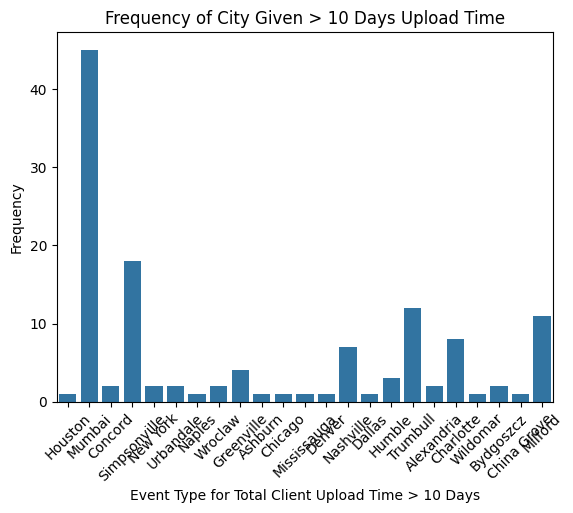

3

In [5]:
# Exploring those with upload times greater than _ days (input in minutes)
filtered_df = df[df['time_difference_minutes'] > 14400]
filtered_df.describe(include='all')

sns.countplot(x='city', data=filtered_df)
plt.xlabel('Event Type for Total Client Upload Time > 10 Days')
plt.ylabel('Frequency')
plt.title('Frequency of City Given > 10 Days Upload Time')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

plt.show()

unique_values_count = df['language'].nunique()
unique_values_count

In [6]:
## Checking to see if client_event_time is the same as event_time

# Creating a dataset with just the client_event_time and event_time columns
new_df = df[['client_event_time', 'event_time']]
new_df.head()

## Check the number of unique values in each column
unique_values = new_df.nunique()

# Check if all columns are equal to eachother in each row
new_df['All_Equal'] = new_df.eq(new_df.iloc[:, 0], axis=0).all(axis=1)

# This code proved that client_event_time = event_time

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_8777/1985162257.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['All_Equal'] = new_df.eq(new_df.iloc[:, 0], axis=0).all(axis=1)


In [7]:
## Performing EDA on columns: client_event_time, client_upload_time, client_uploadtime_difference_minutes
##      which on are on a new dataset titled: client_time_df

client_time_df = df.loc[:,['client_event_time', 'client_upload_time', 'client_uploadtime_difference_minutes']]

# Displays mean, min, 25%, 50%, 75%, max, std on the three columns
client_time_df.describe()

# Find rows where event time is later than upload time
client_time_df.loc[:, 'upload_time_negative'] = client_time_df['client_uploadtime_difference_minutes'] < 0

# Print the rows where the upload time is negative
print(client_time_df[client_time_df['upload_time_negative']])


# Print rows with negative total upload time
#print(client_time_df[client_time_df['upload_time_negative']])

            client_event_time      client_upload_time  \
85    2024-06-14 23:12:06.939 2024-06-14 23:12:06.903   
86    2024-06-14 23:12:06.941 2024-06-14 23:12:06.903   
616   2024-06-03 13:11:45.254 2024-06-03 13:11:44.885   
617   2024-06-03 13:11:45.254 2024-06-03 13:11:44.885   
618   2024-06-03 13:11:45.479 2024-06-03 13:11:45.410   
...                       ...                     ...   
99659 2024-06-17 20:58:09.047 2024-06-17 20:58:08.897   
99660 2024-06-17 20:58:09.062 2024-06-17 20:58:08.897   
99661 2024-06-17 20:58:09.071 2024-06-17 20:58:08.897   
99662 2024-06-17 20:58:09.077 2024-06-17 20:58:08.897   
99663 2024-06-17 20:58:09.082 2024-06-17 20:58:08.897   

       client_uploadtime_difference_minutes  upload_time_negative  
85                                -0.000600                  True  
86                                -0.000633                  True  
616                               -0.006150                  True  
617                               -0.006150

In [8]:
## Combining all 2024 csv files into 1
import glob
csv_files1 = glob.glob('1_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2024combined_file.csv', index=False)


## Combining all 2025 csv files into 1
csv_files2 = glob.glob('2025_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files2], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2025combined_file.csv', index=False)

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_8777/1137695234.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)


In [9]:
# Examining 2024combined_csv
PATH = '2024combined_file.csv'
combined_df_2024 = pd.read_csv(PATH)
combined_df_2024.head()

# Examining 2025combined_csv
PATH = '2025combined_file.csv'
combined_df_2025 = pd.read_csv(PATH)
combined_df_2025.head()


,$insert_id,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_family,...,os_version,platform,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,uuid
0,538ab3f8-09df-4750-90e0-abe8ad8f6a0c,857540493886,591532,Mumbai,2025-01-16 13:28:02.427000,2025-01-16 13:28:04.133000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:06.277000,Maharashtra,2025-01-16 13:28:04.133000,2025-01-16 13:28:04.135000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",006cfd50-7f9e-4ffa-85e8-720404db8247
1,2d9442b9-a8fe-442a-9761-f63fe0171ac5,857540493886,591532,Mumbai,2025-01-16 13:28:02.433000,2025-01-16 13:28:04.133000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:06.277000,Maharashtra,2025-01-16 13:28:04.133000,2025-01-16 13:28:04.135000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",d2b7af18-79b3-4a7f-bf53-022122fea198
2,b39d7ac2-76af-48a6-a367-9e0050359961,857540493886,591532,Mumbai,2025-01-16 13:28:04.229000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",287c085d-27a6-4698-be52-acb0256b8e83
3,57a434dd-d570-4ba2-a77c-de2a4f6be9cf,857540493886,591532,Mumbai,2025-01-16 13:28:04.263000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",cb5b363f-e831-432b-b8d5-272e4219e546
4,fa8af5ee-f45f-4d1a-b1e6-5ea7d293a628,857540493886,591532,Mumbai,2025-01-16 13:28:04.268000,2025-01-16 13:28:06.099000,India,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,131,Web,2025-01-16 13:28:08.007000,Maharashtra,2025-01-16 13:28:06.099000,2025-01-16 13:28:06.101000,1737021244277,0c4896b7-08fa-4cb4-852f-27ad584f0864,"{'businessUnit': [], 'roles': ['underwriter'],...",e4254b14-8af1-4e71-ba6a-085992467fa5


In [100]:
combined_df_2024['client_event_time'] = pd.to_datetime(combined_df_2024['client_event_time'])
combined_df_2024['client_upload_time'] = pd.to_datetime(combined_df_2024['client_upload_time'])
combined_df_2024['time_difference'] = combined_df_2024['client_upload_time'] - combined_df_2024['client_event_time']
combined_df_2024['time_difference_minutes'] = combined_df_2024['time_difference'].dt.total_seconds() / 60

combined_df_2024['time_difference_minutes'].describe()

##

# Exploring those with upload times greater than 10 days (input in minutes)
filtered_df_2024 = combined_df_2024[combined_df_2024['time_difference_minutes'] > 14400]
filtered_df_2024.describe(include='all')

'''''
sns.countplot(x='country', data=filtered_df_2024)
plt.xlabel('Countries with Total Client Upload Time > 10 Days (2024)')
plt.ylabel('Frequency')
plt.title('Frequency of Country Given > 10 Days Upload Time in 2024')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

#plt.show()
'''''

"''\nsns.countplot(x='country', data=filtered_df_2024)\nplt.xlabel('Countries with Total Client Upload Time > 10 Days (2024)')\nplt.ylabel('Frequency')\nplt.title('Frequency of Country Given > 10 Days Upload Time in 2024')\n\n# Rotate x-axis labels if they are crowded\nplt.xticks(rotation=45)\n\n#plt.show()\n"

## Users who had less events in 2025 compared to 2024
1. To ensure an appropriate timeline, I examined the 2025 dataset and discovered the client_event_time were collected over 207 days. I shorted the 2024 dataset starting from the earliest client_event_time (April 14, 2024) and shortened the data to span over 207 days.

2. I created a list of unique user_ids from the filtered 2024 data set that spans over 207 days, and iterated through that list. During each iteration, I went through the combined 2024 dataset to count the number of times that user_id popped up, and did the same for the 2025 dataset. Those user_ids who showed up less in 2025 compared to 2024, indicates a lower retention rate, as those users are using the platform less than previously.

3. To take out any minimal differences, I filtered the data so that the difference of the number of events from 2024 and 2025 were greater than 50. I also created a new column to display that difference. Several key users are those with significant drop in events, and those users who have 0 events in 2025, as they stopped using the platform (drop-off points).


In [117]:
# since the 2025 data set is over 207 days, I will shorten the 2024 data set to be
##      over 207 days as well, starting from the earliest time
combined_df_2024['client_event_time'] = pd.to_datetime(combined_df_2024['client_event_time'])
start_date = '2024-04-14'
end_date = '2024-11-07'

filtered_df_2024 = combined_df_2024[(combined_df_2024['client_event_time'] >= start_date) & (combined_df_2024['client_event_time'] <= end_date)]

# prints all possible unique user_ids from 2024 dataset over 207 days
users_id_list = filtered_df_2024['user_id'].unique()

# Dictionary to store user_id and row counts for each year
user_row_count = {}

# Iterate over each user_id
for user_id in users_id_list:
    # Get the count of rows for the user_id in filtered_df_2024 and filtered_df_2025
    count_2024 = filtered_df_2024[filtered_df_2024['user_id'] == user_id].shape[0]
    count_2025 = combined_df_2025[combined_df_2025['user_id'] == user_id].shape[0]
    
    # Store the row counts
    user_row_count[user_id] = {'user_id': user_id, '2024': count_2024, '2025': count_2025}

# Convert the dictionary to a DataFrame for easier comparison
row_count_df = pd.DataFrame.from_dict(user_row_count, orient='index')

# Filter out users where the number of rows decreased from 2024 to 2025
filtered_users = row_count_df[(row_count_df['2025'] + 50) <= row_count_df['2024']]
userids_dropoffs = filtered_users['user_id'].unique()

# Create a new column to show the difference between 2024 and 2025
filtered_users['difference'] = row_count_df['2024'] - row_count_df['2025']

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_8777/3407974329.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_users['difference'] = row_count_df['2024'] - row_count_df['2025']


## Examining drop-off points
Examining one user_id = '61a2808e-1f12-4e32-b1be-7a62225ade2f' where there is a significant drop in the amount of activity, from 5841 events in 2024 to 0 in 2025.

After examining several columns, the user_id added the 'businessUnit': ['UA Pool'] as time went on. As well, there were more uses of session_end event as time went on. The uses of session_end were 0 in the months April-June 2024, and gradually increased each month afterwards. Due to an increase in session_end events, the duration between client_event_time and client_upload_time have a significant spike between any other events. Thus, I can infer that as the user began to make use of session_end more often, they realized the loading time was much longer than the usualy events with faster times.

As a result, the user stopped using Federato's platform and cannot be found in the 2025 dataset.

In [122]:
# Dictionary to store user_id
dropoff_users_df_2024 = filtered_df_2024[filtered_df_2024['user_id'].isin(userids_dropoffs)]
dropoff_users_df_2025 = combined_df_2025[combined_df_2025['user_id'].isin(userids_dropoffs)]

# Investigate user_id = f9663192-75be-44a6-ad1a-bf4db4a77074
user_2024 = dropoff_users_df_2024[dropoff_users_df_2024['user_id'] == '61a2808e-1f12-4e32-b1be-7a62225ade2f']
user_2025 = dropoff_users_df_2025[dropoff_users_df_2025['user_id'] == '61a2808e-1f12-4e32-b1be-7a62225ade2f']

                                                                   user_id  \
125c9087-fbca-4778-a86e-d03332c127fc  125c9087-fbca-4778-a86e-d03332c127fc   
61a2808e-1f12-4e32-b1be-7a62225ade2f  61a2808e-1f12-4e32-b1be-7a62225ade2f   
871ee2be-7f0a-474b-9e33-cc29a4889121  871ee2be-7f0a-474b-9e33-cc29a4889121   
1b98c6bb-b6b9-4b9a-a62f-6a31fb18ada4  1b98c6bb-b6b9-4b9a-a62f-6a31fb18ada4   
a3a47efd-4443-45b2-ae6e-85756b563898  a3a47efd-4443-45b2-ae6e-85756b563898   
...                                                                    ...   
0fa9ac2a-c33f-492c-ba5b-8b4933fc1006  0fa9ac2a-c33f-492c-ba5b-8b4933fc1006   
d01e89e5-f6b1-4737-bee0-eafd00679b82  d01e89e5-f6b1-4737-bee0-eafd00679b82   
d7088c42-2c28-d1d4-f0c7-352e7b8611ec  d7088c42-2c28-d1d4-f0c7-352e7b8611ec   
1adda23e-0432-434f-9a66-994feceae381  1adda23e-0432-434f-9a66-994feceae381   
bc372c02-8133-467c-8964-6ea649cd5ca5  bc372c02-8133-467c-8964-6ea649cd5ca5   

                                      2024  2025  difference  


## Stickiness over a 28 day period
To measure stickiness, we nust determine the time spent per day on the Federato platforn across all sessions over a 28-day period. Using the dates on client_event_time, the earliest date is April 14, 2024, and the latest is January 28, 2025. Which in total displays 10 28-day periods.

First I will examine the first 28-day period: April 14, 2024 - May 12, 2024

Date: 2024-05-12, Total Time Spent: 4.011516666666666 minutes
[np.float64(4.011516666666666), np.float64(0.23516666666666666), np.float64(0.2913), np.float64(1.4894333333333334), np.float64(7.33135), np.float64(0.0), np.float64(1.4895666666666667), np.float64(0.0), np.float64(-4.92413333333333), np.float64(8896294.647550002), np.float64(4.92765), np.float64(7.886000000000003), np.float64(6.5043500000000005), np.float64(897.3173166666666), np.float64(2.96475), np.float64(992.0177500000001), np.float64(23.148699999999998), np.float64(0.0), np.float64(0.0), np.float64(-7.3694500000000005), np.float64(2.750166666666667), np.float64(1.7894166666666667), np.float64(36.04528333333333), np.float64(124.08306666666664), np.float64(0.0), np.float64(2.896216666666666), np.float64(4425.6402333333335), np.float64(8.345133333333333)]


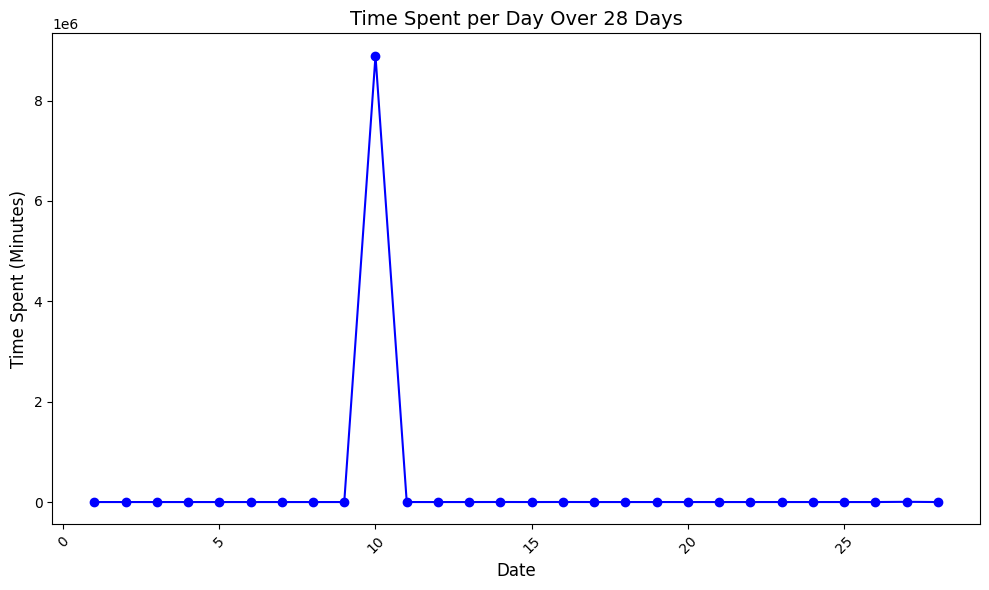

In [176]:
start_date = pd.to_datetime('2024-04-14')
end_date = pd.to_datetime('2024-05-12')

first_period_2024 = combined_df_2024[(combined_df_2024['client_event_time'] >= start_date) & (combined_df_2024['client_event_time'] <= end_date)]

# Number of users in first period
first_period_2024['user_id'].nunique() # 456 users




# Initialize an empty list to store the total time spent per day
total_time_spent_per_day = []

# Loop over each day in the date range (28 days)
for i in range(28):
    # Filter the DataFrame for the current date
    filtered_data = combined_df_2024[(combined_df_2024['client_event_time'].dt.date >= start_date.date()) & 
                                     (combined_df_2024['client_event_time'].dt.date < (start_date + pd.Timedelta(days=1)).date())]
    
    # Sum the 'total_time_spent_minutes' for that date
    total_time = filtered_data['time_difference_minutes'].sum()
    
    # Append the total time spent to the list
    total_time_spent_per_day.append(total_time)
    
    # Increment the date by 1 day for the next iteration
    start_date += pd.Timedelta(days=1)
    
# Print the results
for date, time_spent in zip(pd.date_range(start=start_date, end=end_date), total_time_spent_per_day):
    print(f"Date: {date.date()}, Total Time Spent: {time_spent} minutes")

print(total_time_spent_per_day)

## Plotting
# Plot the time spent per day over the 28-day period
plt.figure(figsize=(10, 6))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], total_time_spent_per_day, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Time Spent per Day Over 28 Days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Time Spent (Minutes)', fontsize=12)

# Formatting the x-axis for better readability (showing date as YYYY-MM-DD)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


## Without the outlier
We will investigate the 11th-28th days

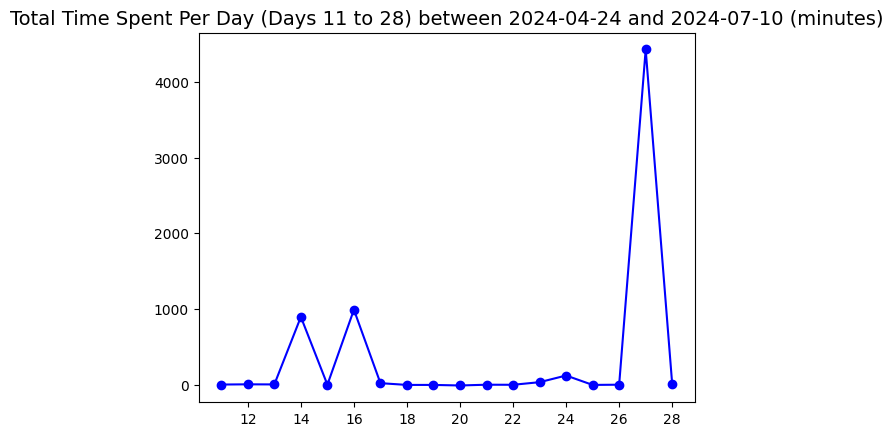

In [177]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.plot([11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], total_time_spent_per_day[10:], marker='o', linestyle='-', color='b')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Total Time Spent Per Day (Days 11 to 28) between 2024-04-24 and 2024-07-10 (minutes)", fontsize=14)
plt.show()

# Insights from user retention on a 28-day period
From this 28-day period, there were 2 significant spikes on days: 
- 2024-04-24 (Wednesday)
- 2024-05-11 (Saturday)

## Return Users (28-day period in 2024)

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_8777/151309510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_period_2024['timestamp'] = pd.to_datetime(first_period_2024['client_event_time'])


                                  $insert_id  amplitude_id     app       city  \
660339  5019b94b-e1fc-4ff8-8ad3-e9bfd1c5d632  857540567657  591532   New York   
660340  d55b2352-7edc-4135-9e79-3ea32286bf1e  857540567657  591532   New York   
660341  0c121ebf-4e19-427c-a2b1-6e2529df7187  857540567657  591532   New York   
660342  7cd24445-ab8f-484a-b560-8d189d7de9ac  857540567657  591532   New York   
660343  4e33af74-2cfd-44cd-ab9b-b91732b0aba9  857540567657  591532   New York   
...                                      ...           ...     ...        ...   
580851  9d38dd43-76d6-4112-8dbd-9d61e81fd29d  891686495132  591532    Chicago   
522250  a165a972-31ec-4dfb-b4b4-b118365aba87  892725872991  591532   Boardman   
581390  fd1932e8-5a92-4cd0-95ee-cfeed02be675  893717073725  591532  Maryville   
602627  f0146dc8-2787-4eb8-986b-135de5b9ebb6  893617884867  591532   Boardman   
617649  8418806c-56b1-4db2-b33f-59cf509219ba  894506692727  591532   Boardman   

             client_event_t

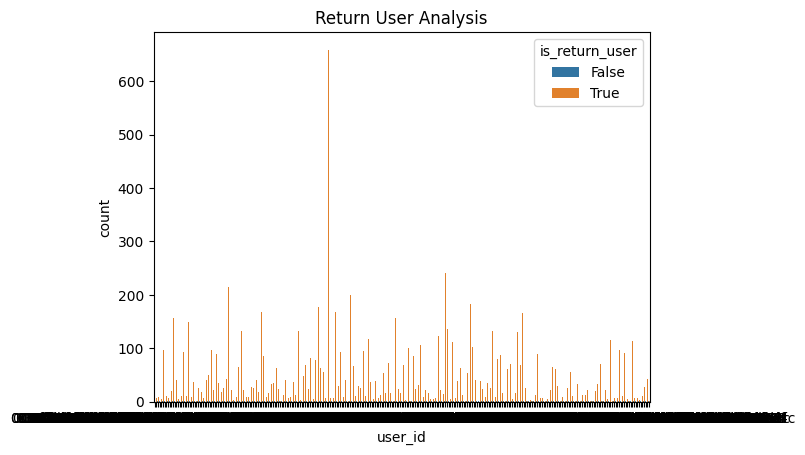

In [178]:
# Convert timestamp to datetime
first_period_2024['timestamp'] = pd.to_datetime(first_period_2024['client_event_time'])

# Sort by user and timestamp
first_period_2024 = first_period_2024.sort_values(by=['user_id', 'client_event_time'])

# Calculate time difference between visits for each user
first_period_2024['time_diff'] = first_period_2024.groupby('user_id')['client_event_time'].diff()

# Define the threshold for "return" (e.g., 1 day)
return_threshold = pd.Timedelta(days=1)

# Apply the comparison element-wise
first_period_2024['is_return'] = first_period_2024['time_diff'].apply(lambda x: x <= return_threshold if pd.notnull(x) else False)

# Display the dataframe with return status
print(first_period_2024)






# Find the first interaction for each user
first_interaction = first_period_2024.groupby('user_id')['client_event_time'].min().reset_index()
first_interaction.columns = ['user_id', 'first_timestamp']

# Merge with the original data
df_with_first = pd.merge(first_period_2024, first_interaction, on='user_id')

# Calculate return time (difference between visit and first interaction)
df_with_first['time_from_first'] = df_with_first['client_event_time'] - df_with_first['first_timestamp']

# Flag return users (if time_from_first > 0 means return visit)
df_with_first['is_return_user'] = df_with_first['time_from_first'] > pd.Timedelta(0)

# Display data
print(df_with_first)

# Plot the return rate by user
sns.countplot(data=df_with_first, x='user_id', hue='is_return_user')
plt.title('Return User Analysis')
plt.show()


# Cohort Analysis per Day of the 28-day Period

In [181]:
# Define cohorts based on the first registration date (e.g., by month)
df_with_first['cohort'] = df_with_first['first_timestamp'].dt.to_period('D')

# Group by cohort and calculate return rates
cohort_analysis = df_with_first.groupby(['cohort', 'is_return_user']).size().unstack(fill_value=0)

# Calculate return rate for each cohort
cohort_analysis['return_rate'] = cohort_analysis[True] / (cohort_analysis[True] + cohort_analysis[False])

# Display cohort analysis
print(cohort_analysis)

is_return_user  False  True  return_rate
cohort                                  
2024-04-14          2   297     0.993311
2024-04-16          2    34     0.944444
2024-04-17          2    65     0.970149
2024-04-18         31   516     0.943327
2024-04-20          3   494     0.993964
2024-04-22         80  4966     0.984146
2024-04-24          6   201     0.971014
2024-04-25         45  1556     0.971893
2024-04-26          3   217     0.986364
2024-04-29         66  3257     0.980138
2024-04-30         21  1150     0.982067
2024-05-03          2    29     0.935484
2024-05-06         13   231     0.946721
2024-05-07         17   187     0.916667
2024-05-10          3    11     0.785714
2024-05-11          1   183     0.994565


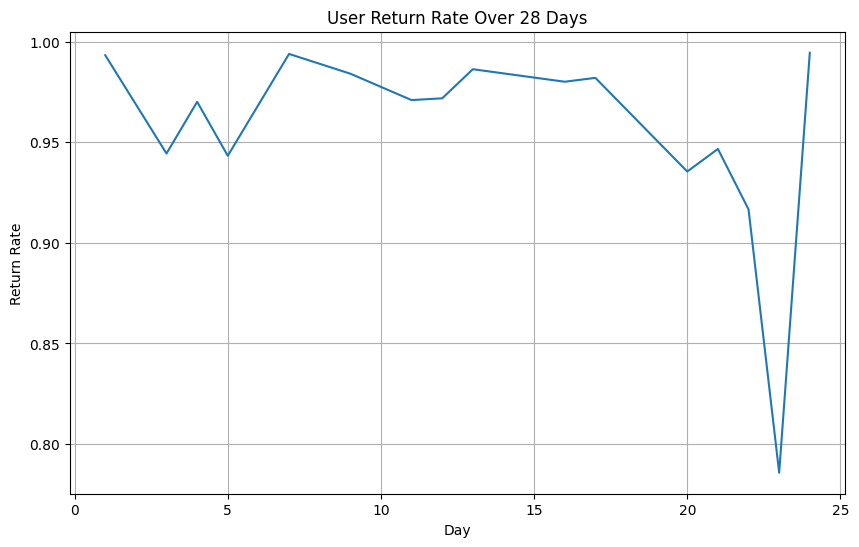

In [186]:
# Plot return rate over the 28-day period
plt.figure(figsize=(10, 6))
sns.lineplot(data=cohort_analysis, x=[1,3,4,5,7,9,11,12,13,16,17,20,21,22,23,24], y='return_rate')
plt.title('User Return Rate Over 28 Days')
plt.xlabel('Day')
plt.ylabel('Return Rate')
plt.grid(True)
plt.show()

In [180]:
x = combined_df_2024[(combined_df_2024['client_event_time'] >= pd.to_datetime('2024-05-03')) & (combined_df_2024['client_event_time'] < pd.to_datetime('2024-05-04'))]
print(x)

                                  $insert_id  amplitude_id     app    city  \
519363  be2b6889-5886-4fe0-aa2e-a871a9466005  857540435842  591532  Mumbai   
519364  6e926493-2d56-47c4-bac4-0a7c0562f1f5  857540435842  591532  Mumbai   
519365  e14997e1-903a-4cd2-bbce-b1407c1d5517  857540435842  591532  Mumbai   
519366  9f5beb46-0db7-4d92-9eaf-192b1ca9514c  857540435842  591532  Mumbai   
519367  9c996afa-e838-47b5-9d76-89f76eda2fce  857540435842  591532  Mumbai   
...                                      ...           ...     ...     ...   
555303  e39cc394-39d0-477c-9ec7-4dd42f9c354d  857541114956  591532   Miami   
555304  cf785077-2623-4adf-a6f4-11e38f0a3451  857541114956  591532   Miami   
555305  f1061b53-e161-43e5-9826-37b70ec269e5  857541114956  591532   Miami   
555306  7732f56b-e31c-4ec9-9ee3-a791fef8c6cc  857540799881  591532  Denver   
555307  256cab27-816a-4357-84c5-072992047068  857540799881  591532  Denver   

             client_event_time      client_upload_time        c

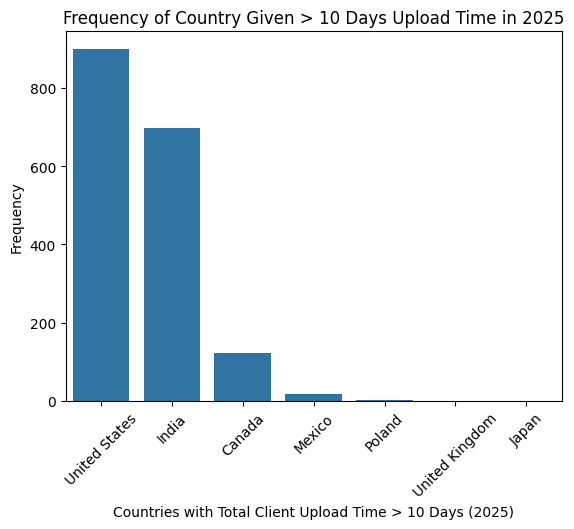

In [ ]:
combined_df_2025['client_event_time'] = pd.to_datetime(combined_df_2025['client_event_time'])
combined_df_2025['client_upload_time'] = pd.to_datetime(combined_df_2025['client_upload_time'])
combined_df_2025['time_difference'] = combined_df_2025['client_upload_time'] - combined_df_2025['client_event_time']
combined_df_2025['time_difference_minutes'] = combined_df_2025['time_difference'].dt.total_seconds() / 60

combined_df_2025['time_difference_minutes'].describe()

##

# Exploring those with upload times greater than 10 days (input in minutes)
filtered_df_2025 = combined_df_2025[combined_df_2025['time_difference_minutes'] > 14400]
filtered_df_2025.describe(include='all')

sns.countplot(x='country', data=filtered_df_2025)
plt.xlabel('Countries with Total Client Upload Time > 10 Days (2025)')
plt.ylabel('Frequency')
plt.title('Frequency of Country Given > 10 Days Upload Time in 2025')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

plt.show()